# Fermi Hubbard Ground State Energy Estimation with Quantum Circuits

In [1]:
import networkx as nx
import openfermion as of
import numpy as np
import matplotlib.pyplot as plt
import time
import cirq
import os
from pyLIQTR.utils.utils import count_T_gates, open_fermion_to_qasm
from pyLIQTR.gate_decomp.cirq_transforms import clifford_plus_t_direct_transform
from cirq.contrib.qasm_import import circuit_from_qasm
from pyLIQTR.GSE.GSE import GSE
from pyLIQTR.QSP.qsp_helpers import qsp_decompose_once

Consider the two orbital tight binding Fermi Hubbard Model for cuprate superconductors (seen for example [here](http://sces.phys.utk.edu/publications/Pub2011/7-FOP-11107-ED.pdf)) on a square lattice:

\begin{equation}
\begin{split}
    H_{TB} & = -t_1 \sum_{i,\sigma} \left( d^{\dagger}_{i,x,\sigma}d_{i+\hat{y},x,\sigma} +  d^{\dagger}_{i,y,\sigma}d_{i+\hat{x}, y, \sigma} + h.c. \right) \\
           & -t_2 \sum_{i,\sigma} \left( d^{\dagger}_{i,x,\sigma}d_{i+\hat{x},x,\sigma} +  d^{\dagger}_{i,y,\sigma}d_{i+\hat{y}, y, \sigma} + h.c. \right) \\
           & -t_3 \sum_{i,\hat{\mu}, \hat{\nu},\sigma} \left( d^{\dagger}_{i,x,\sigma}d_{i+\hat{\mu} + \hat{\nu},x,\sigma} +  d^{\dagger}_{i,y,\sigma}d_{i+\hat{\mu} + \hat{\nu}, y, \sigma} + h.c. \right) \\
           & +t_4 \sum_{i,\sigma} \left( d^{\dagger}_{i,x,\sigma}d_{i+\hat{x}+\hat{y},y,\sigma} +  d^{\dagger}_{i,y,\sigma}d_{i+\hat{x}+\hat{y},x,\sigma} + h.c. \right) \\
           & -t_4 \sum_{i,\sigma} \left( d^{\dagger}_{i,x,\sigma}d_{i+\hat{x}-\hat{y},y,\sigma} +  d^{\dagger}_{i,y,\sigma}d_{i+\hat{x}-\hat{y},x,\sigma} + h.c. \right) \\
           & -\mu \sum_{i} \left( n_{i}^{x} + n_{i}^{y} \right)
\end{split}
\end{equation}

where $t_1 = -1.0, t_2 = 1.3, t_3 = t_4 = -0.85$ with operators $d^{\dagger}_{i,\alpha,\sigma}$ and $d_{i,\alpha,\sigma}$ respectively create or annihilate electrons on an atom at site $i$, with orbital $\alpha$, and spin $\sigma$.  The operator $n^{\alpha}_{i}$ represents the number operator of an atom at a given orbital, i.e. $n^x_i = \sum_{\sigma} \left( d^{\dagger}_{i,x,\sigma} d_{i,x,\sigma} \right)$. The indices in the Hamiltonian are assigned in the following manner: the index $i$ will correspond to a 2-tuple $(m,n)$ indicating the x and y coordinates of the atom in the lattice.  Since there are 2 orbitals, $\alpha \in \{x,y\}$.  Lastly, $\sigma \in \{\uparrow, \downarrow \}$.  For the sake of simplicity of coding, we will remap these labels to integer values, meaning we will assign indices $m \in L_x, n \in L_y, a \in \mathbb{Z}^2, s \in \mathbb{Z}^2$ where $L_x$ is the $x$ dimension of the square lattice, and $L_y$ is the $y$ dimension of the square lattice.  In the summations, $\hat{x}$ and $\hat{y}$ correspond to adjacent sites in the lattice, rather than the orbitals.  The summation over unit vectors $\hat{\mu}$ and $\hat{\nu}$ correspond to the summing over unit vectors in all 8 cardinal and intercardinal directions without double counting.

In [2]:
def count_gates(cpt_circuit):
    count = 0
    for moment in cpt_circuit:
        for operator in moment:
            count += 1
    return count

def flatten_nx_graph(g):
    new_ids = {}
    count = 0
    for node in g.nodes:
        if node in new_ids:
            pass
        else:
            new_ids[node] = count
            count = count + 1
    new_g = nx.relabel_nodes(g, new_ids)
    return new_g

def num_fermion_qubits(ham):
    n_qubits = 0
    for term in ham.terms:
        for op in term:
            qubit = op[0]
            if qubit >= n_qubits:
                n_qubits = qubit+1
    return n_qubits

def generate_two_orbital_nx(Lx,Ly):
    #can combine logic between loops if this is slow
    g = nx.Graph()
    for m in range(Lx):
        for n in range(Ly):
            for a in range(2):
                for s in range(2):
                    g.add_node((m,n,a,s), pos=(m+a*(Lx+1),n+s*(Ly+1)))
    
    for m in range(Lx):
        for n in range(Ly):
            for s in range(2):
                #t_1 terms
                n1, n2 = (m,n,0,s), (m,n+1,0,s)
                n3, n4 = (m,n,1,s), (m+1,n,1,s)
                if n2 in g:
                    g.add_edge(n1,n2,label="-t1")
                if n4 in g:
                    g.add_edge(n3,n4,label="-t1")
   
                #t_2 terms
                n1, n2 = (m,n,0,s), (m+1,n,0,s)
                n3, n4 = (m,n,1,s), (m,n+1,1,s)
                if n2 in g:
                    g.add_edge(n1,n2,label="-t2")
                if n4 in g:
                    g.add_edge(n3,n4,label="-t2")
    
                #t_3 terms
                n1, n2 = (m,n,0,s), (m+1,n+1,0,s)
                n3, n4 = (m,n,1,s), (m+1,n+1,1,s)
                if n2 in g:
                    g.add_edge(n1,n2,label="-t3")
                if n4 in g:
                    g.add_edge(n3,n4,label="-t3")
                
                n1, n2 = (m,n,0,s), (m+1,n-1,0,s)
                n3, n4 = (m,n,1,s), (m+1,n-1,1,s)
                if n2 in g:
                    g.add_edge(n1,n2,label="-t3")
                if n4 in g:
                    g.add_edge(n3,n4,label="-t3")
                    
                n1, n2 = (m,n,0,s), (m+1,n,0,s)
                n3, n4 = (m,n,1,s), (m+1,n,1,s)
                if n2 in g:
                    g.add_edge(n1,n2,label="-t3")
                if n4 in g:
                    g.add_edge(n3,n4,label="-t3")
                
                n1, n2 = (m,n,0,s), (m,n+1,0,s)
                n3, n4 = (m,n,1,s), (m,n+1,1,s)
                if n2 in g:
                    g.add_edge(n1,n2,label="-t3")
                if n4 in g:
                    g.add_edge(n3,n4,label="-t3")
                
                #+t_4 terms
                n1, n2 = (m,n,0,s), (m+1,n+1,1,s)
                n3, n4 = (m,n,1,s), (m+1,n+1,0,s)
                if n2 in g:
                    g.add_edge(n1,n2,label="+t4")
                if n4 in g:
                    g.add_edge(n3,n4,label="+t4")
                
                #-t4 terms
                n1, n2 = (m,n,0,s), (m+1,n-1,1,s)
                n3, n4 = (m,n,1,s), (m+1,n-1,0,s)
                if n2 in g:
                    g.add_edge(n1,n2,label="-t4")
                if n4 in g:
                    g.add_edge(n3,n4,label="-t4")
    return g

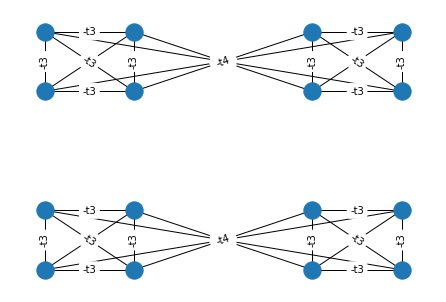

In [3]:
g_example = generate_two_orbital_nx(2,2)
pos = nx.get_node_attributes(g_example, 'pos')
edge_labels = dict([((n1, n2), d['label']) for n1, n2, d in g_example.edges(data=True)]);
nx.draw(g_example, pos)
nx.draw_networkx_edge_labels(g_example,pos, edge_labels = edge_labels);

In [4]:
def nx_to_two_orbital_hamiltonian(g, t1, t2, t3, t4, mu):
    g_flat = flatten_nx_graph(g)
    H = of.FermionOperator()
    
    # generating hopping terms on each edge
    for i,j,d in g_flat.edges(data=True):
        w = 0
        label = d['label']
        if label == "-t1":
            w = -t1
        elif label == "-t2":
            w = -t2
        elif label == "-t3":
            w = -t3
        elif label == "-t4":
            w = -t4
        elif label == "+t4":
            w = t4
        else:
            raise ValueError("Graph improperly labeled")
            
        H += of.FermionOperator(((i,1),(j,0)),w)
        H += of.FermionOperator(((j,1),(i,0)),w)
    
    #applying number operator to each qubit
    for i in g_flat.nodes:
        H += of.FermionOperator(((i,1), (i,0)), -mu)
    
    return H

In [5]:
t1 = -1
t2 = 1.3
t3 = 0.85
t4 = 0.85
mu = 1
nx_to_two_orbital_hamiltonian(g_example, t1, t2, t3, t4, mu)

-1.0 [0^ 0] +
-0.85 [0^ 4] +
-0.85 [0^ 8] +
-0.85 [0^ 12] +
0.85 [0^ 14] +
-1.0 [1^ 1] +
-0.85 [1^ 5] +
-0.85 [1^ 9] +
-0.85 [1^ 13] +
0.85 [1^ 15] +
-1.0 [2^ 2] +
-0.85 [2^ 6] +
-0.85 [2^ 10] +
0.85 [2^ 12] +
-0.85 [2^ 14] +
-1.0 [3^ 3] +
-0.85 [3^ 7] +
-0.85 [3^ 11] +
0.85 [3^ 13] +
-0.85 [3^ 15] +
-0.85 [4^ 0] +
-1.0 [4^ 4] +
-0.85 [4^ 8] +
-0.85 [4^ 10] +
-0.85 [4^ 12] +
-0.85 [5^ 1] +
-1.0 [5^ 5] +
-0.85 [5^ 9] +
-0.85 [5^ 11] +
-0.85 [5^ 13] +
-0.85 [6^ 2] +
-1.0 [6^ 6] +
-0.85 [6^ 8] +
-0.85 [6^ 10] +
-0.85 [6^ 14] +
-0.85 [7^ 3] +
-1.0 [7^ 7] +
-0.85 [7^ 9] +
-0.85 [7^ 11] +
-0.85 [7^ 15] +
-0.85 [8^ 0] +
-0.85 [8^ 4] +
-0.85 [8^ 6] +
-1.0 [8^ 8] +
-0.85 [8^ 12] +
-0.85 [9^ 1] +
-0.85 [9^ 5] +
-0.85 [9^ 7] +
-1.0 [9^ 9] +
-0.85 [9^ 13] +
-0.85 [10^ 2] +
-0.85 [10^ 4] +
-0.85 [10^ 6] +
-1.0 [10^ 10] +
-0.85 [10^ 14] +
-0.85 [11^ 3] +
-0.85 [11^ 5] +
-0.85 [11^ 7] +
-1.0 [11^ 11] +
-0.85 [11^ 15] +
-0.85 [12^ 0] +
0.85 [12^ 2] +
-0.85 [12^ 4] +
-0.85 [12^ 8] +
-1.0 [12^ 12] +
-0.

In [6]:
g_current_limit = generate_two_orbital_nx(6,7)
g_ideal = generate_two_orbital_nx(10,10)

##### START UNCOMMENT FOR TESTING
#n_test = 2
#g_current_limit = generate_two_orbital_nx(n_test,n_test)  
#g_ideal = generate_two_orbital_nx(n_test,n_test)
##### END UNCOMMENT FOR TESTING
n_qubits_current_limit = len(g_current_limit)
n_qubits_ideal = len(g_ideal)

In [7]:
ham_current_limit = nx_to_two_orbital_hamiltonian(g_current_limit,t1,t2,t3,t4,mu)
ham_ideal = nx_to_two_orbital_hamiltonian(g_ideal,t1,t2,t3,t4,mu)
trotter_order_current_limit = 2
trotter_steps_current_limit = 1

trotter_order_ideal = 2
trotter_steps_ideal = 1

#note that we would actually like ~10 bits of precision, it just takes a really long time to run
bits_precision_ideal = 1
bits_precision_current_limit = 1

current_limit_args = {
    'trotterize' : True,
    'mol_ham'    : ham_current_limit,
    'ev_time'    : 1,
    'trot_ord'   : trotter_order_current_limit,
    'trot_num'   : trotter_steps_current_limit
}

ideal_args = {
    'trotterize' : True,
    'mol_ham'    : ham_ideal,
    'ev_time'    : 1,
    'trot_ord'   : trotter_order_ideal,
    'trot_num'   : trotter_steps_ideal
}

In [8]:
E_min_ideal = -len(ham_ideal.terms)
E_max_ideal = 0

E_min_current_limit = -len(ham_current_limit.terms)
E_max_current_limit = 0

init_state_ideal = [0] * n_qubits_ideal
init_state_current_limit = [0] * n_qubits_current_limit

print("starting")
t0 = time.perf_counter()
gse_inst_current_limit = GSE(
    precision_order=bits_precision_current_limit,
    init_state=init_state_current_limit,
    E_max = E_max_current_limit,
    E_min = E_min_current_limit,
    include_classical_bits=False, # Do this so print to openqasm works
    kwargs=current_limit_args)
t1 = time.perf_counter()
print("current limit time to generate high level: ", t1 - t0)

t0 = time.perf_counter()
gse_inst_ideal = GSE(
    precision_order=bits_precision_ideal,
    init_state=init_state_ideal,
    E_max = E_max_ideal,
    E_min = E_min_ideal,
    include_classical_bits=False, # Do this so print to openqasm works
    kwargs=ideal_args)
t1 = time.perf_counter()
print("ideal time to generate high level: ", t1 - t0)

gse_circuit_ideal = gse_inst_ideal.pe_inst.pe_circuit
gse_circuit_current_limit = gse_inst_current_limit.pe_inst.pe_circuit

starting
current limit time to generate high level:  0.6936667519999995
ideal time to generate high level:  3.5612669230000007


In [9]:
def estimate_gse(circuit, outdir, circuit_name="gse_circuit", write_circuits=False):
    if not os.path.exists(outdir):
        os.makedirs(outdir)
    
    subcircuit_counts = dict()
    t_counts = dict()
    clifford_counts = dict()
    gate_counts = dict()
    subcircuit_depths = dict()
    
    outfile_data = outdir+circuit_name+"_high_level.dat"
    
    for moment in circuit:
        for operation in moment:
            gate_type = type(operation.gate)
            if gate_type in subcircuit_counts:
                subcircuit_counts[gate_type] += 1
            else:
                decomposed_circuit = qsp_decompose_once(qsp_decompose_once(cirq.Circuit(operation)))
                cpt_circuit = clifford_plus_t_direct_transform(decomposed_circuit)
                
                outfile_qasm_decomposed = outdir+str(gate_type)[8:-2]+".decomposed.qasm"
                outfile_qasm_cpt = outdir+str(gate_type)[8:-2]+".cpt.qasm"
                
                if write_circuits:
                    with open(outfile_qasm_decomposed, 'w') as f:
                        print_to_openqasm(f, decomposed_circuit, qubits=decomposed_circuit.all_qubits())
                    
                    with open(outfile_qasm_cpt, 'w') as f:
                        print_to_openqasm(f, cpt_circuit, qubits=cpt_circuit.all_qubits())
                
                subcircuit_counts[gate_type] = 1
                subcircuit_depths[gate_type] = len(cpt_circuit)
                t_counts[gate_type] = count_T_gates(cpt_circuit)
                gate_counts[gate_type] = count_gates(cpt_circuit)
                clifford_counts[gate_type] = gate_counts[gate_type] - t_counts[gate_type]
                
                
    total_gate_count = 0
    total_gate_depth = 0
    total_T_count = 0
    total_clifford_count = 0
    for gate in subcircuit_counts:
        total_gate_count += subcircuit_counts[gate] * gate_counts[gate]
        total_gate_depth += subcircuit_counts[gate] * subcircuit_depths[gate]
        total_T_count += subcircuit_counts[gate] * t_counts[gate]
        total_clifford_count += subcircuit_counts[gate] * clifford_counts[gate]
    with open(outfile_data, 'w') as f:
        total_gate_count 
        f.write(str("Logical Qubit Count:"+str(len(circuit.all_qubits()))+"\n"))
        f.write(str("Total Gate Count:"+str(total_gate_count)+"\n"))
        f.write(str("Total Gate Depth:"+str(total_gate_depth)+"\n"))
        f.write(str("Total T Count:"+str(total_T_count)+"\n"))
        f.write(str("Total Clifford Count:"+str(total_clifford_count)+"\n"))
        f.write("Subcircuit Info:\n")
        for gate in subcircuit_counts:
            f.write(str(str(gate)+"\n"))
            f.write(str("Subcircuit Occurrences:"+str(subcircuit_counts[gate])+"\n"))
            f.write(str("Gate Count:"+str(gate_counts[gate])+"\n"))
            f.write(str("Gate Depth:"+str(subcircuit_depths[gate])+"\n"))
            f.write(str("T Count:"+str(t_counts[gate])+"\n"))
            f.write(str("Clifford Count:"+str(clifford_counts[gate])+"\n"))

In [10]:
print("Estimating Ideal")
t0 = time.perf_counter()
estimate_gse(gse_circuit_ideal, outdir="GSE/", circuit_name="ideal")
t1 = time.perf_counter()
print("Time to estimate Ideal:", t1-t0)

print("Estimating Current Limit")
t0 = time.perf_counter()
estimate_gse(gse_circuit_current_limit, outdir="GSE/", circuit_name="current_limit")
t1 = time.perf_counter()
print("Time to estimate Current Limit:", t1-t0)

Estimating Ideal
Time to estimate Ideal: 1577.596524861
Estimating Current Limit
Time to estimate Current Limit: 310.04503533
